# Semantic Segmentation Brain Tumor

### Overview of the project

Semantic segmentation is a task in computer vision where the objective is to classify every pixel of an image into specific categories or objects.
The project aims to identify tumor regions accurately using deep learning techniques. In particular, the UNet artificial network will handle classifying every pixel in an image as part of a tumor or non-tumor region.



### Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerie

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import json
import numpy as np
import skimage.draw
import cv2
import tifffile
import shutil
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import numpy as np
import random
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import time
from tqdm import tqdm

## Data visualizzation

Code for data visualization taken from:
https://www.kaggle.com/code/nithunith/brain-tumor-unet

In [ ]:
def display_masks(image_names, data):
    fig , ax = plt.subplots(2,2,figsize = (15,15))
    for i, img_path in enumerate(image_names):
        draw_image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]
        points_list = img_annotations[0]['segmentation']
        points = np.array(points_list, np.int32)
        points = points.reshape((-1,1,2))
        # Draw polygon
        cv2.polylines(draw_image,[points],True,(0,0,255),3)

        # Display the image
        ax[i//2, i%2].imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

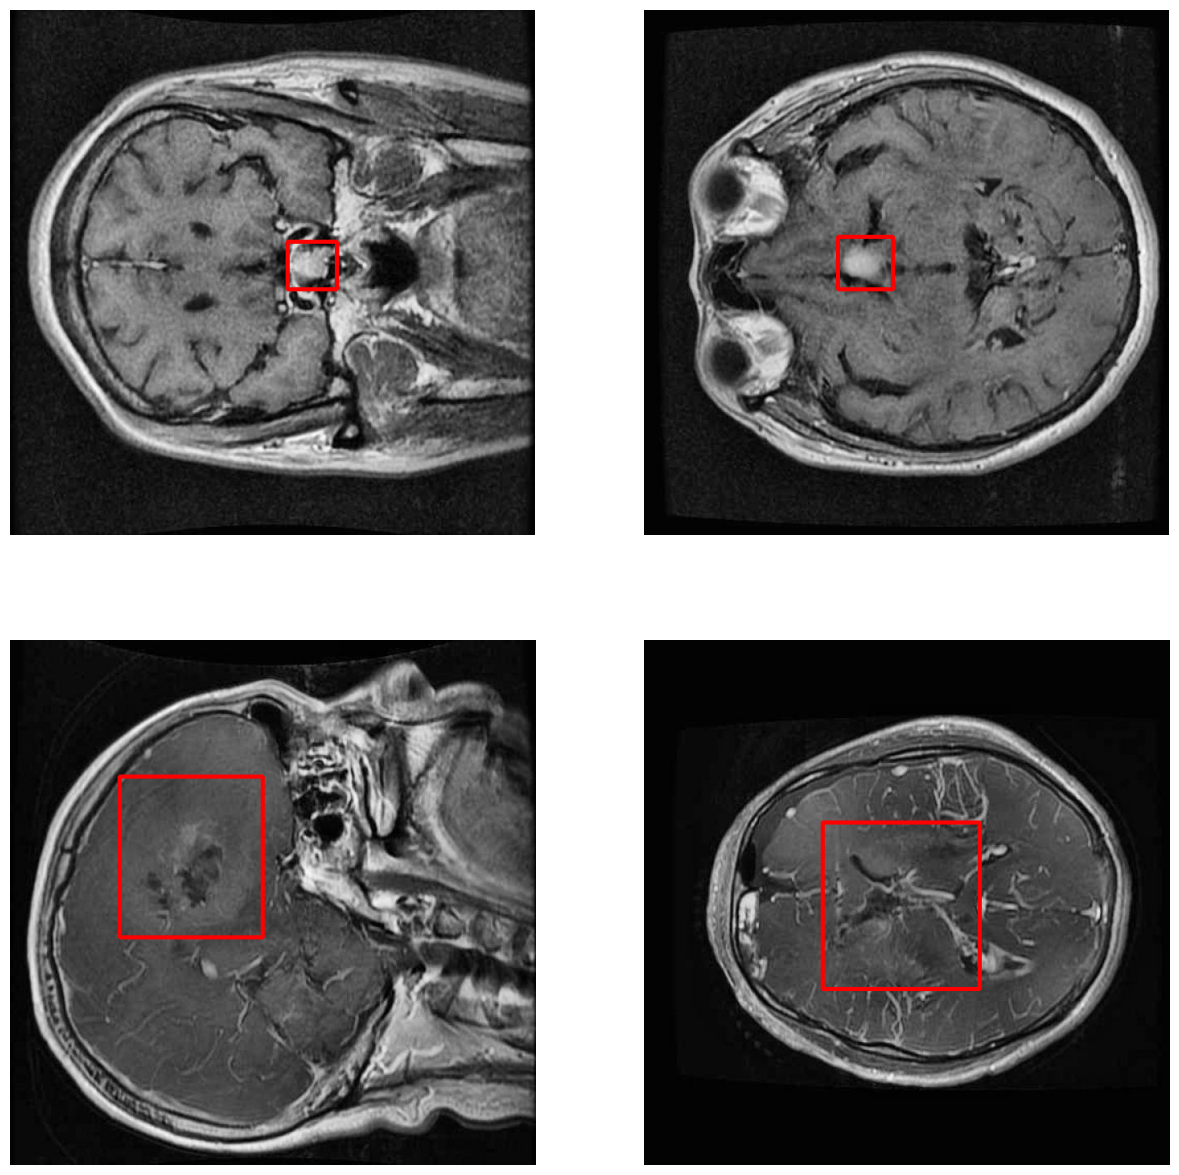

In [ ]:
with open('/content/drive/Shareddrives/Brain_tumor_segment/valid/_annotations.coco.json','r') as file:
    annotations = json.load(file)
#get all the image files
imge_dir = "/content/drive/Shareddrives/Brain_tumor_segment/valid"
all_image_files = [os.path.join(imge_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files,4)
#call the draw mask function
display_masks(random_image_files,annotations)

## Data preparetion

The dataset consists of 2146 images, divided into 1502 for the training set, 429 for the validation set, and 215 for the test set. Tumors are annotated in COCO Segmentation format.

### Masks

Code for masks generation taken from: https://www.kaggle.com/code/kevin114514/brain-tumor-unet-zoo

The function create_mask() generates the associated segmentation mask for each image from the annotations.json file and saves them as TIFF images. The used image and the created mask are saved in a new folder, which will consist of a folder with the used image and a folder with the generated mask.

In [ ]:
def create_mask(image_info, annotations, output_folder, max_print=3):
    mask_np =np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)
    obj_number = 1
    printed_masks = 0;
    for ann in annotations:
        if image_info['id'] == ann['image_id']:
            for seg_idx ,seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                seg_mask = np.zeros_like(mask_np,dtype=np.uint8)
                seg_mask[rr,cc] = 255
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return

In [ ]:
def main(json_file,mask_output_folder,image_output_folder,original_image_dir):
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    for img in images:
        create_mask(img, annotations, mask_output_folder)
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)

In [ ]:
## Test
original_image_dir = '/content/drive/Shareddrives/Brain_tumor_segment/test'               ## Directory where the test folder of the dataset is saved
json_file = '/content/drive/Shareddrives/Brain_tumor_segment/test/_annotations.coco.json' ## In the same directory, we take the coco annotation json file
mask_output_folder = '/content/drive/Shareddrives/Brain_tumor_segment/test2/masks'        ## Insert the path of the new folder in which we save the generated segmentation masks
image_output_folder = '/content/drive/Shareddrives/Brain_tumor_segment/test2/images'      ## Insert the path of the new folder in which we save the image used for mask generation
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

## Train
original_image_dir = '/content/drive/Shareddrives/Brain_tumor_segment/train'
json_file = '/content/drive/Shareddrives/Brain_tumor_segment/train/_annotations.coco.json'
mask_output_folder = '/content/drive/Shareddrives/Brain_tumor_segment/train2/masks'
image_output_folder = '/content/drive/Shareddrives/Brain_tumor_segment/train2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

## Validation
original_image_dir = '/content/drive/Shareddrives/Brain_tumor_segment/valid'
json_file = '/content/drive/Shareddrives/Brain_tumor_segment/valid/_annotations.coco.json'
mask_output_folder = '/content/drive/Shareddrives/Brain_tumor_segment/valid2/masks'
image_output_folder = '/content/drive/Shareddrives/Brain_tumor_segment/valid2/images'
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

#### Delete the image without the mask

For a couple of images in the training set, the mask is not generated. The issues with the generation are due to the JSON annotations; other users have encountered the same problem and solved it by removing those images, so we choose to do the same.

In [ ]:
def compare_folders(folder1,folder2):
    folder1_items = os.listdir(folder1)
    folder2_items = os.listdir(folder2)

    for item1 in folder1_items:
        f =False

        for j in folder2_items:
            if item1[:4] == j[:4]:
                f=True
                break
        if not f:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    for item2 in folder2_items:
        f =False

        for j in folder1_items:
            if item2[:4] == j[:4]:
                f=True
                break
        if not f:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2, item2)
            os.remove(item1_path)
            print(f"Deleted {item1}")

folder1_path = "/content/drive/Shareddrives/Brain_tumor_segment/train2/images"
folder2_path = "/content/drive/Shareddrives/Brain_tumor_segment/train2/masks"
compare_folders(folder1_path, folder2_path)

folder1_path = "/content/drive/Shareddrives/Brain_tumor_segment/test2/images"
folder2_path = "/content/drive/Shareddrives/Brain_tumor_segment/test2/masks"
compare_folders(folder1_path, folder2_path)

folder1_path = "/content/drive/Shareddrives/Brain_tumor_segment/valid2/images"
folder2_path = "/content/drive/Shareddrives/Brain_tumor_segment/valid2/masks"
compare_folders(folder1_path, folder2_path)


### Datasets

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)
        return image_gray,mask

In [ ]:
train_path = "/content/drive/Shareddrives/Brain_tumor_segment/train2"
valid_path = "/content/drive/Shareddrives/Brain_tumor_segment/valid2"
test_path = "/content/drive/Shareddrives/Brain_tumor_segment/test2"


image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

train_dataset = BrainTumorDataset(train_path, transform = image_transform)
valid_dataset = BrainTumorDataset(valid_path, transform=image_transform)
test_dataset = BrainTumorDataset(test_path, transform=image_transform)

### Visualizzazione

Mostriamo le prime 5 maschere create per le prime 5 immagini

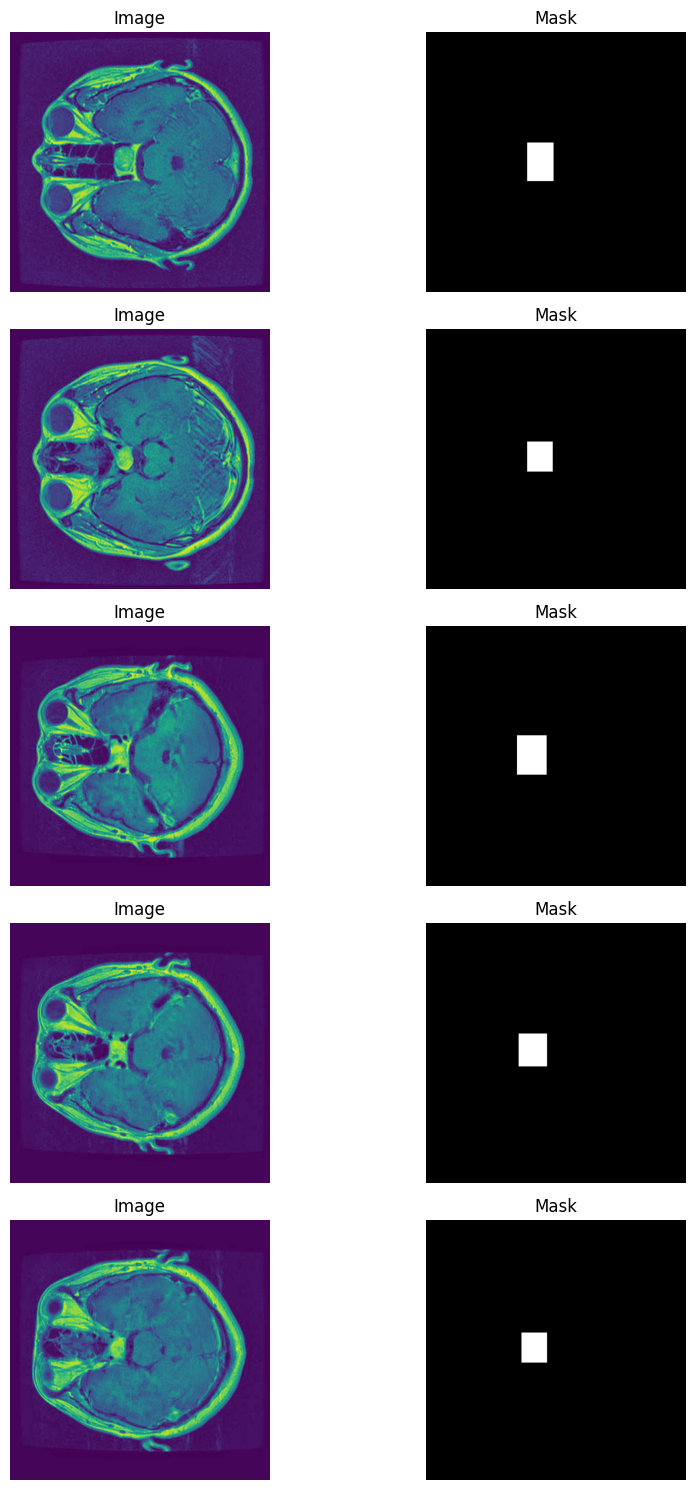

In [ ]:
dataset = BrainTumorDataset(train_path)
fig,axs = plt.subplots(5,2,figsize=(10,15))
for i in range(5):
    image, mask = dataset[i]
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

## Modelli

###U_Net Ottimizzata
NOTE: Performance più alte ottenute

- *Convoluzioni dilatate*: Aggiungere convoluzioni dilatate può aiutare a espandere il campo ricettivo e catturare contesti più ampi senza aumentare il costo computazionale.

- *Normalizzazione*: Cambiare la tecnica di normalizzazione, ad esempio provando Group Normalization o Instance Normalization, può influire sulle prestazioni a seconda del tipo e della dimensione del dataset.



In [ ]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    """
    Convolution Block with dilated convolutions and Group Normalization to increase the receptive field.
    """
    def __init__(self, in_ch, out_ch, dilation=1, num_groups=8):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=dilation, bias=True, dilation=dilation),
            nn.GroupNorm(num_groups, out_ch),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=dilation, bias=True, dilation=dilation),
            nn.GroupNorm(num_groups, out_ch),
            nn.LeakyReLU(negative_slope=0.01, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class up_conv(nn.Module):
    """
    Up Convolution Block with Group Normalization.
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)

class U_Net(nn.Module):
    """
    UNet - Basic Implementation with Group Normalization.
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0], dilation=1)
        self.Conv2 = conv_block(filters[0], filters[1], dilation=2)
        self.Conv3 = conv_block(filters[1], filters[2], dilation=4)
        self.Conv4 = conv_block(filters[2], filters[3], dilation=8)
        self.Conv5 = conv_block(filters[3], filters[4], dilation=16)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out


### Addestramento

In [ ]:
learning_rate = 1e-3
num_epochs = 120
n_channels = 1
n_classes = 1

device = 'cuda'

network = U_Net(n_channels, n_classes)

network = network.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True, num_workers = 4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle=False, num_workers = 4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=False)

def dice_loss(pred, target, smooth = 1.):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=[2,3])
    union = pred.sum(dim=[2,3]) + target.sum(dim=[2,3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def train(num_epochs, train_loader, valid_loader, model, criterion, optimizer, device,  patience=10):
    train_avg_loss = []
    valid_avg_loss = []
    valid_dice = []

    best_loss = float('inf')
    no_improve_epoch = 0

    for epoch in tqdm(range(num_epochs), desc='Training Progress'):
        model.train()
        train_losses = []

        for i, (x, y) in enumerate(train_loader):
            print(f"Training batch {i+1}/{len(train_loader)}")
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        train_loss = torch.tensor(train_losses).mean()
        train_avg_loss.append(train_loss)

        model.eval()
        valid_losses = []
        dice_scores = []
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                valid_losses.append(loss.item())
                dice_scores.append(dice_loss(pred, y).item())


        valid_loss = torch.tensor(valid_losses).mean()
        valid_avg_loss.append(valid_loss)
        mean_dice = torch.tensor(dice_scores).mean()
        valid_dice.append(mean_dice)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Dice Coefficient: {mean_dice:.4f}")

        if mean_dice > best_loss:
            best_loss = mean_dice
            no_improve_epoch = 0
            print("Validation loss decreased, saving model...")
            torch.save(model.state_dict(), '/content/drive/Shareddrives/Brain_tumor_segment/savebestmodel/best_model_Ros.pth')
        else:
            no_improve_epoch += 1
            print(f"No improvement in validation loss for {no_improve_epoch} epochs.")
            if no_improve_epoch >= patience:
                print("Early stopping triggered.")
                break



    return train_avg_loss, valid_avg_loss, valid_dice


train_avg_loss, valid_avg_loss, valid_dice = train(num_epochs, train_loader, valid_loader, network, criterion, optimizer, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Training Progress:   0%|          | 0/120 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
Training batch 43/94
Training batch 44/94
Training batch 45/94
Training batch 46/94
Training batch 47/94
Training batch 48/94
T

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training Progress:   1%|          | 1/120 [09:13<18:18:21, 553.79s/it]

Epoch 1/120, Train Loss: 0.1459, Valid Loss: 0.1149, Dice Coefficient: 0.0009
No improvement in validation loss for 1 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   2%|▏         | 2/120 [10:50<9:20:28, 284.98s/it] 

Epoch 2/120, Train Loss: 0.1087, Valid Loss: 0.1040, Dice Coefficient: 0.2099
No improvement in validation loss for 2 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   2%|▎         | 3/120 [12:26<6:27:43, 198.83s/it]

Epoch 3/120, Train Loss: 0.0969, Valid Loss: 0.0953, Dice Coefficient: 0.3575
No improvement in validation loss for 3 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   3%|▎         | 4/120 [14:03<5:06:16, 158.42s/it]

Epoch 4/120, Train Loss: 0.0900, Valid Loss: 0.0923, Dice Coefficient: 0.2472
No improvement in validation loss for 4 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   4%|▍         | 5/120 [15:40<4:21:11, 136.27s/it]

Epoch 5/120, Train Loss: 0.0848, Valid Loss: 0.0860, Dice Coefficient: 0.3720
No improvement in validation loss for 5 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   5%|▌         | 6/120 [17:17<3:53:34, 122.93s/it]

Epoch 6/120, Train Loss: 0.0804, Valid Loss: 0.0807, Dice Coefficient: 0.4212
No improvement in validation loss for 6 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   6%|▌         | 7/120 [18:53<3:34:55, 114.12s/it]

Epoch 7/120, Train Loss: 0.0768, Valid Loss: 0.0795, Dice Coefficient: 0.5200
No improvement in validation loss for 7 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   7%|▋         | 8/120 [20:29<3:22:32, 108.50s/it]

Epoch 8/120, Train Loss: 0.0746, Valid Loss: 0.0767, Dice Coefficient: 0.4559
No improvement in validation loss for 8 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   8%|▊         | 9/120 [22:06<3:13:45, 104.73s/it]

Epoch 9/120, Train Loss: 0.0713, Valid Loss: 0.0782, Dice Coefficient: 0.4433
No improvement in validation loss for 9 epochs.
Training batch 1/94
Training batch 2/94
Training batch 3/94
Training batch 4/94
Training batch 5/94
Training batch 6/94
Training batch 7/94
Training batch 8/94
Training batch 9/94
Training batch 10/94
Training batch 11/94
Training batch 12/94
Training batch 13/94
Training batch 14/94
Training batch 15/94
Training batch 16/94
Training batch 17/94
Training batch 18/94
Training batch 19/94
Training batch 20/94
Training batch 21/94
Training batch 22/94
Training batch 23/94
Training batch 24/94
Training batch 25/94
Training batch 26/94
Training batch 27/94
Training batch 28/94
Training batch 29/94
Training batch 30/94
Training batch 31/94
Training batch 32/94
Training batch 33/94
Training batch 34/94
Training batch 35/94
Training batch 36/94
Training batch 37/94
Training batch 38/94
Training batch 39/94
Training batch 40/94
Training batch 41/94
Training batch 42/94
T

Training Progress:   8%|▊         | 9/120 [23:42<4:52:21, 158.03s/it]

Epoch 10/120, Train Loss: 0.0711, Valid Loss: 0.0739, Dice Coefficient: 0.4790
No improvement in validation loss for 10 epochs.
Early stopping triggered.


In [ ]:
model = U_Net(n_channels, n_classes)
model.load_state_dict(torch.load('/content/drive/Shareddrives/Brain_tumor_segment/savebestmodel/best_model_Ros.pth'))
model.eval()

U_Net(
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): Leaky

### Valutazione sul Test set

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    dice_scores = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            test_losses.append(loss.item())
            dice_scores.append(dice_loss(pred, y).item())

    test_loss = torch.tensor(test_losses).mean()
    mean_dice = torch.tensor(dice_scores).mean()
    print(f"Test Loss: {test_loss:.4f}, Dice Coefficient: {mean_dice:.4f}")

# Evaluate the model on the test dataset
evaluate(network, test_loader, criterion, device)


Test Loss: 0.0770, Dice Coefficient: 0.4709


### Grafici

Grafico della loss sul Training e Validation set

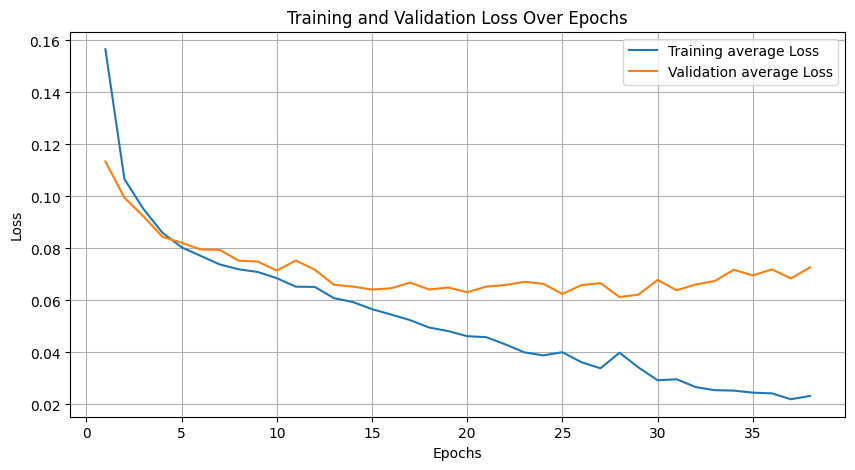

In [ ]:
epochs = range(1, len(train_avg_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_avg_loss, label='Training average Loss')
plt.plot(epochs, valid_avg_loss, label='Validation average Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Grafico della Dice metrics sul validation set

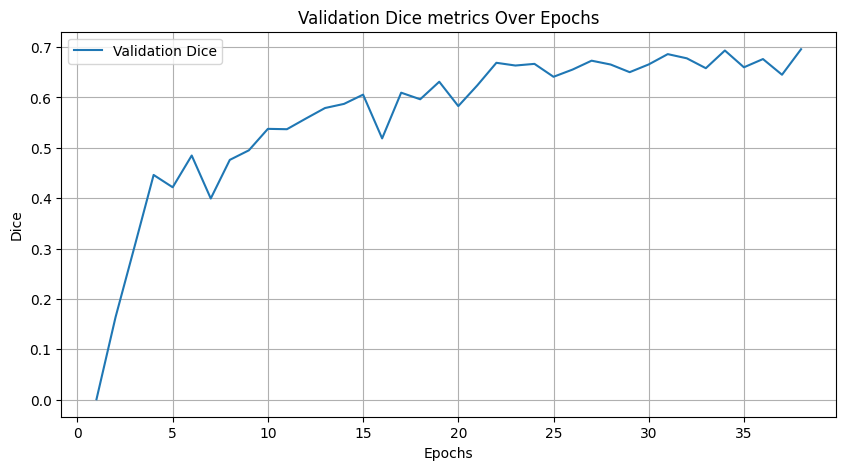

In [ ]:
epochs = range(1, len(train_avg_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, valid_dice, label='Validation Dice')
plt.title('Validation Dice metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)
plt.show()

### Visualizzazione risultati

In [ ]:
def visualize_input_output_target(input_image, output_image, target_image):
    # Move tensors to CPU memory if they are on CUDA devices
    input_image = input_image.cpu()
    output_image = output_image.cpu()
    target_image = target_image.cpu()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot input image
    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Plot output image (predicted binary mask)
    axes[1].imshow(output_image.squeeze().numpy(), cmap='gray')
    axes[1].set_title('Output Image (Predicted)')
    axes[1].axis('off')

    # Plot target image (ground truth binary mask)
    axes[2].imshow(target_image.squeeze().numpy(), cmap='gray')
    axes[2].set_title('Target Image (Ground Truth)')
    axes[2].axis('off')

    plt.show()
    fig.savefig("output.png")

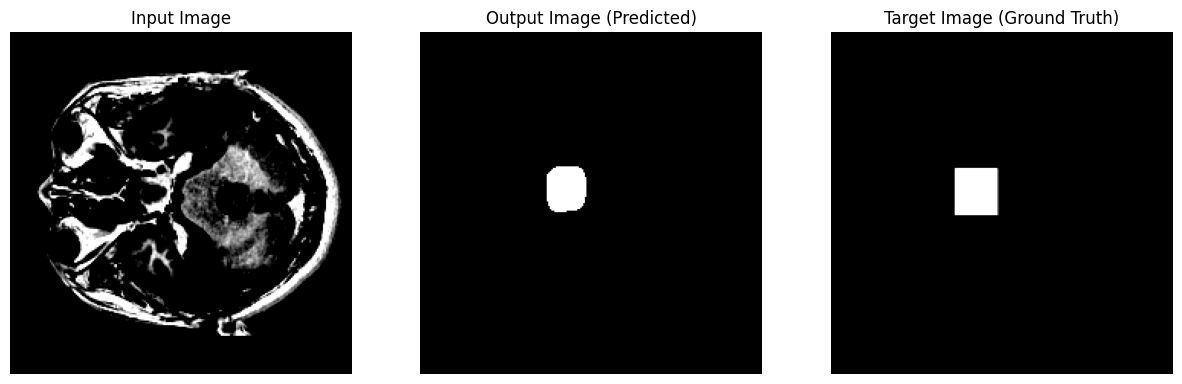

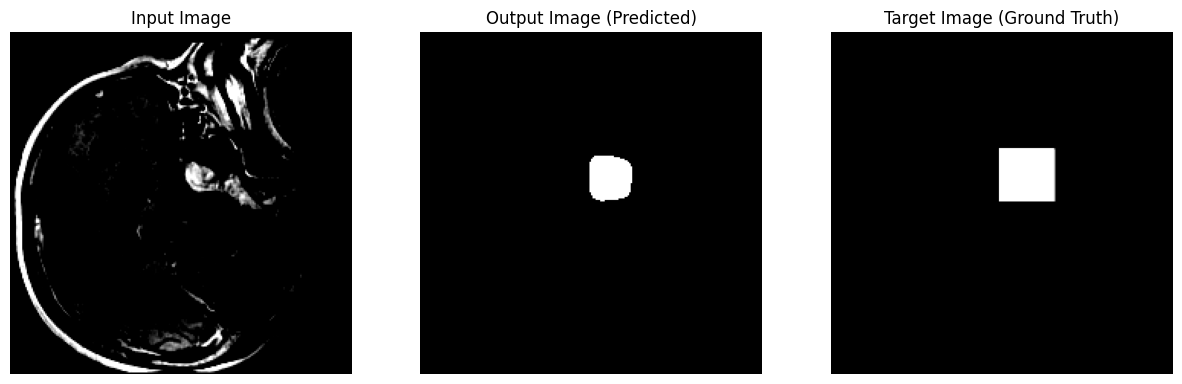

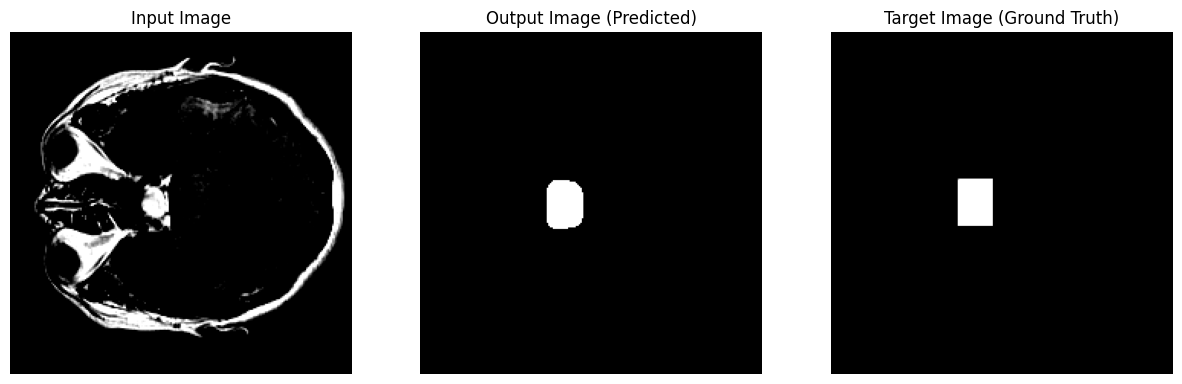

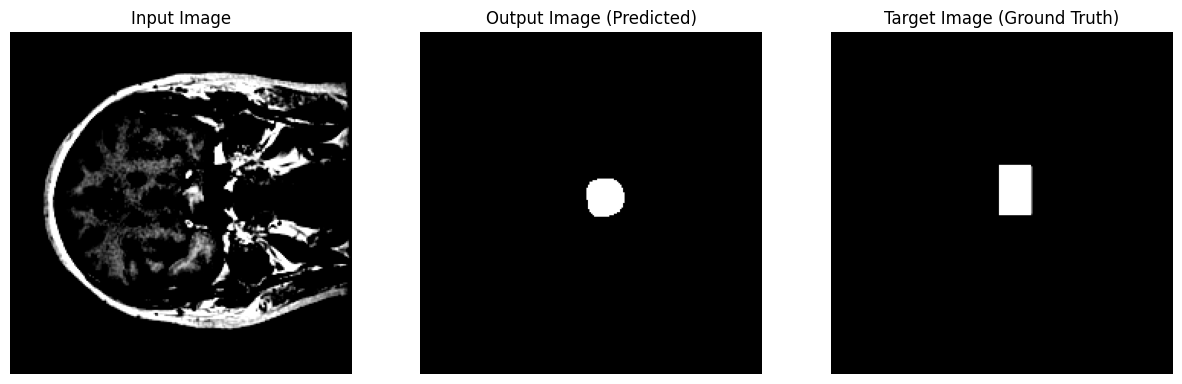

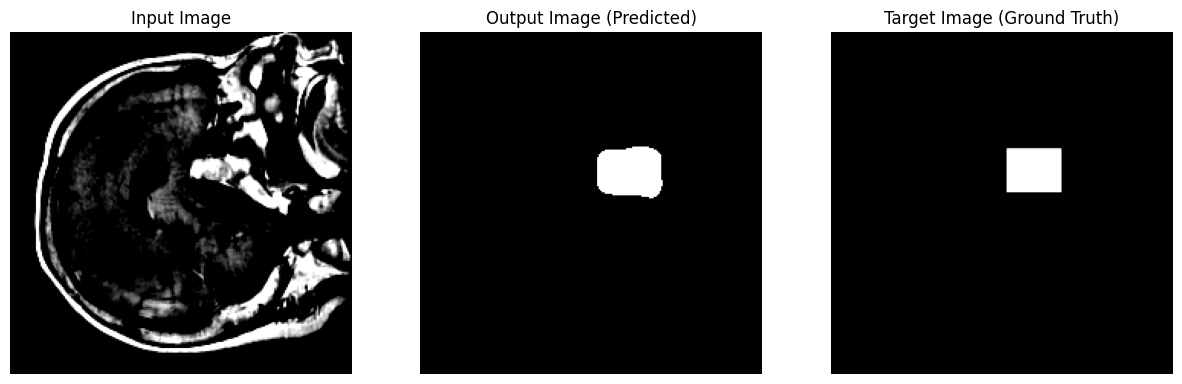

In [ ]:
idx =0
for x,y in test_loader:
    x  = x.to(device,dtype = torch.float32)
    y =  y.to(device,dtype = torch.float32)

    pred = network(x)
    y_pred = (pred>0.5).float()
    if idx <5:
        visualize_input_output_target(x[0],y_pred[0],y[0])
    idx +=1